### import packages

In [1]:
from pydicom import dcmread
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import six
import statistics as stat
import seaborn as sns

### read structure set and image metadata

In [2]:
path = 'MR_Phantom_scans/DICOM_RT_CT_fusion_September/'
filename = 'RTSS.dcm'
image = 'IMG0000000100.dcm'
ds = dcmread(path + filename)
image = dcmread(path + image)

###  extract spacing and origin coordinates

In [3]:
x_spacing = float(image.PixelSpacing[0])
y_spacing = float(image.PixelSpacing[1])

x_origin = image.ImagePositionPatient[0]
y_origin = image.ImagePositionPatient[1]

slice_thickness = image.SliceThickness
OM = image.PositionReferenceIndicator

#### prepare main pandas dataframe and lists for data

In [4]:
my_dict = {}
col_name = ['ROI Number', 'ROI Name']
df = pd.DataFrame(columns=col_name)
ROINumbers = []
ROINames = []
ROIDisplayColors = []
ContourDatas = []

### transformation of coordinates and writing them into the dataframe

In [5]:
for i in ds.StructureSetROISequence:
    ROINumbers.append(i.ROINumber)
    ROINames.append(i.ROIName)
    
for i in ds.ROIContourSequence:
    ROIDisplayColors.append(i.ROIDisplayColor)
    ContourSequences = []
    if "ContourSequence" in i:  
        for k in i.ContourSequence:
            contour_array = []
#             linear transformation of coordinates
            for j in range(0, len(k.ContourData), 3):
                contour_array.append(round(((k.ContourData[j] - x_origin)/x_spacing), 2))
                contour_array.append(round(((k.ContourData[j+1] - y_origin)/y_spacing), 2))
                contour_array.append(k.ContourData[j+2])
            ContourSequences.append(contour_array)
    ContourDatas.append(ContourSequences)

my_dict['ROI Numbers'] = ROINumbers
my_dict['ROI Names'] = ROINames
my_dict['ROI Display Colors'] = ROIDisplayColors
my_dict['Contour Data'] = ContourDatas
df = df.from_dict(my_dict)

### find all possible z slices and find phantom center

In [6]:
possibleZ = []
for q in df['Contour Data']:
    for i in q:
        possibleZ.append(i[2])
possibleZ = list(set(possibleZ))
possibleZ.sort()
z_mean = stat.mean(possibleZ)
z_center = (z_mean//slice_thickness)*slice_thickness    

### print dataframe

In [7]:
for q in df['Contour Data']:
    for i in q:
        for j in range(0, len(i)-2, 3):
            i[j+2] = i[j+2] + 100 - z_center
df

possibleZ = []
for q in df['Contour Data']:
    for i in q:
        possibleZ.append(i[2])
possibleZ = list(set(possibleZ))
possibleZ.sort()

In [8]:
Names = df['ROI Names'].tolist()
Names = Names[:-1:]
# Names = Names[::10]

### create 3 dataframes for CT, T1 and T2 contours

In [27]:
df_CT = df[df['ROI Names'].str.contains('CT')].copy().reset_index()
df_T1 = df[df['ROI Names'].str.contains('T1')].copy().reset_index()
df_T2 = df[df['ROI Names'].str.contains('T2')].copy().reset_index()

,index,ROI Numbers,ROI Names,ROI Display Colors,Contour Data
0,0,1,1_T2,"[255, 99, 71]","[[159.59, 238.86, 118.5, 159.63, 239.05, 118.5..."
1,3,4,2_T2,"[255, 165, 0]","[[183.26, 238.79, 117.25, 183.2, 239.3, 117.25..."
2,6,7,3_T2,"[255, 165, 0]","[[206.29, 168.82, 118.5, 206.26, 169.21, 118.5..."
3,10,11,4_T2,"[255, 165, 0]","[[252.8, 286.4, 117.25, 252.73, 286.6, 117.25,..."
4,13,14,5_T2,"[255, 165, 0]","[[252.83, 215.77, 117.25, 252.83, 215.77, 117...."


In [28]:
df_CT.head()


,index,ROI Numbers,ROI Names,ROI Display Colors,Contour Data
0,2,3,2_CT,"[0, 191, 255]","[[180.26, 239.19, 152.25, 180.36, 238.75, 152...."
1,5,6,3_CT,"[0, 255, 255]","[[203.49, 169.14, 152.25, 203.58, 168.7, 152.2..."
2,8,9,1_CT,"[0, 255, 255]","[[156.56, 238.71, 152.25, 156.66, 238.56, 152...."
3,9,10,4_CT,"[0, 191, 255]","[[250.22, 285.97, 151.0, 250.32, 285.77, 151.0..."
4,12,13,5_CT,"[0, 255, 255]","[[250.42, 215.42, 151.0, 250.51, 215.27, 151.0..."


In [29]:
df_T1.head()


,index,ROI Numbers,ROI Names,ROI Display Colors,Contour Data
0,1,2,1_T1,"[255, 0, 255]","[[160.16, 239.57, 146.0, 160.14, 239.77, 146.0..."
1,4,5,2_T1,"[255, 0, 255]","[[183.84, 239.78, 144.75, 183.76, 240.02, 144...."
2,7,8,3_T1,"[255, 0, 255]","[[207.68, 169.93, 146.0, 207.61, 170.19, 146.0..."
3,11,12,4_T1,"[255, 0, 255]","[[253.18, 286.7, 146.0, 253.14, 286.79, 146.0,..."
4,14,15,5_T1,"[255, 0, 255]","[[252.98, 216.75, 146.0, 253.04, 216.8, 146.0,..."


In [51]:
df_T2.head()

,index,ROI Numbers,ROI Names,ROI Display Colors,Contour Data
0,0,1,1_T2,"[255, 99, 71]","[[159.59, 238.86, 118.5, 159.63, 239.05, 118.5..."
1,3,4,2_T2,"[255, 165, 0]","[[183.26, 238.79, 117.25, 183.2, 239.3, 117.25..."
2,6,7,3_T2,"[255, 165, 0]","[[206.29, 168.82, 118.5, 206.26, 169.21, 118.5..."
3,10,11,4_T2,"[255, 165, 0]","[[252.8, 286.4, 117.25, 252.73, 286.6, 117.25,..."
4,13,14,5_T2,"[255, 165, 0]","[[252.83, 215.77, 117.25, 252.83, 215.77, 117...."


In [10]:
CTcontours = dict.fromkeys(possibleZ, [])
for z in possibleZ:
    contours = []
    for CTrod in df_CT['Contour Data']:
        for CTcontour in CTrod:
            if CTcontour[2] == z:
                contours.append(CTcontour)
    CTcontours[z] = contours

T1contours = dict.fromkeys(possibleZ, [])
for z in possibleZ:
    contours = []
    for T1rod in df_T1['Contour Data']:
        for T1contour in T1rod:
            if T1contour[2] == z:
                contours.append(T1contour)
    T1contours[z] = contours
    
    
T2contours = dict.fromkeys(possibleZ, [])
for z in possibleZ:
    contours = []
    for T2rod in df_T2['Contour Data']:
        for T2contour in T2rod:
            if T2contour[2] == z:
                contours.append(T2contour)
    T2contours[z] = contours
df_zcoord = pd.DataFrame({'zcoord': possibleZ, 'CT_contours': list(CTcontours.values()), 'T1_contours': list(T1contours.values()), 'T2_contours': list(T2contours.values())}).set_index('zcoord')

In [54]:
CTcontours = dict.fromkeys(possibleZ, [])
for z in possibleZ:
    contours = []
    for CTrod in df_CT['Contour Data']:
        for CTcontour in CTrod:
            if CTcontour[2] == z:
                print(df_CT[CTrod]['ROI Names'])
                contours.append([1, CTcontour])
    CTcontours[z] = contours

T1contours = dict.fromkeys(possibleZ, [])
for z in possibleZ:
    contours = []
    for T1rod in df_T1['Contour Data']:
        for T1contour in T1rod:
            if T1contour[2] == z:
                contours.append([2, T1contour])
    T1contours[z] = contours
    
    
T2contours = dict.fromkeys(possibleZ, [])
for z in possibleZ:
    contours = []
    for T2rod in df_T2['Contour Data']:
        for T2contour in T2rod:
            if T2contour[2] == z:
                contours.append([3, T2contour])
    T2contours[z] = contours
df_zcoord = pd.DataFrame({'zcoord': possibleZ, 'CT_contours': list(CTcontours.values()), 'T1_contours': list(T1contours.values()), 'T2_contours': list(T2contours.values())}).set_index('zcoord')

/home/perseusf/anaconda3/envs/MRIphantom/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


TypeError: unhashable type: 'list'

In [49]:
df_zcoord.head()

,CT_contours,T1_contours,T2_contours
zcoord,,,
47.25,"[[1, [320.69, 330.45, 47.25, 320.84, 330.3, 47...",[],[]
48.50,"[[1, [249.59, 283.24, 48.5, 249.69, 282.99, 48...",[],[]
49.75,"[[1, [155.68, 237.04, 49.75, 155.78, 236.46, 4...",[],[]
51.00,"[[1, [179.09, 236.85, 51.0, 179.19, 236.31, 51...",[],[]
52.25,"[[1, [179.09, 236.75, 52.25, 179.19, 236.17, 5...",[],[]


## Отрисовка контура и его центра
1. Предполагается, что точки отмечены равномерно, нет "перекосов" в ту или иную сторону.
2. Через список Names передаем те контуры, которые необходимо отрисовать (по умолчанию все).

In [11]:
print(possibleZ)

[47.25, 48.5, 49.75, 51.0, 52.25, 53.5, 54.75, 56.0, 57.25, 58.5, 59.75, 61.0, 62.25, 63.5, 64.75, 66.0, 67.25, 68.5, 69.75, 71.0, 72.25, 73.5, 74.75, 76.0, 77.25, 78.5, 79.75, 81.0, 82.25, 83.5, 84.75, 86.0, 87.25, 88.5, 89.75, 91.0, 92.25, 93.5, 94.75, 96.0, 97.25, 98.5, 99.75, 101.0, 102.25, 103.5, 104.75, 106.0, 107.25, 108.5, 109.75, 111.0, 112.25, 113.5, 114.75, 116.0, 117.25, 118.5, 119.75, 121.0, 122.25, 123.5, 124.75, 126.0, 127.25, 128.5, 129.75, 131.0, 132.25, 133.5, 134.75, 136.0, 137.25, 138.5, 139.75, 141.0, 142.25, 143.5, 144.75, 146.0, 147.25, 148.5, 149.75, 151.0, 152.25, 153.5]


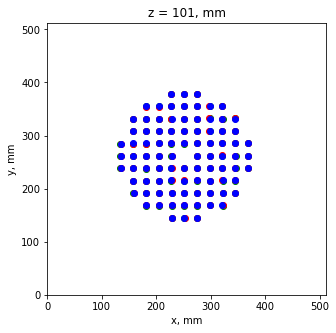

In [41]:
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)

z_coord = 101
for contour in df_zcoord.loc[z_coord]['CT_contours']:
    x = contour[0::3]
    y = contour[1::3]
    plt.scatter(stat.mean(x),stat.mean(y), color='green')
    
    
for contour in df_zcoord.loc[z_coord]['T1_contours']:
    x = contour[0::3]
    y = contour[1::3]
    plt.scatter(stat.mean(x),stat.mean(y), color='red')
    
    
for contour in df_zcoord.loc[z_coord]['T2_contours']:
    x = contour[0::3]
    y = contour[1::3]
    plt.scatter(stat.mean(x),stat.mean(y), color='blue')
    
plt.ylabel('y, mm')
plt.xlabel('x, mm')
plt.xlim([0, 512])
plt.ylim([0, 512])
plt.title(f"z = {z_coord}, mm")

plt.show()

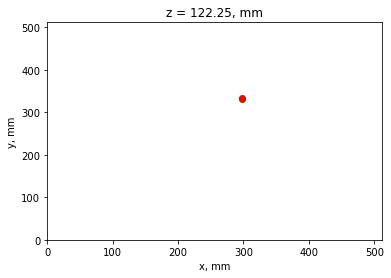

In [45]:
z_coord = 122.25
cont_num = 50
plt.scatter(stat.mean(df_zcoord.loc[z_coord]['CT_contours'][cont_num][0::3]),\
            stat.mean(df_zcoord.loc[z_coord]['CT_contours'][cont_num][1::3]),\
            color='green');

plt.scatter(stat.mean(df_zcoord.loc[z_coord]['T1_contours'][cont_num][0::3]),\
            stat.mean(df_zcoord.loc[z_coord]['T1_contours'][cont_num][1::3]),\
            color='red');

plt.ylabel('y, mm')
plt.xlabel('x, mm')
plt.xlim([0, 512])
plt.ylim([0, 512])
plt.title(f"z = {z_coord}, mm")

plt.show()